In [2]:
# --- 0) INSTALL DEPENDENCIES ---

# Install TensorFlow
#!pip install tensorflow -q

# Install PyTorch and YOLOv5 dependencies
#!pip install torch torchvision -q
#!pip install ultralytics -q

# Verify installations
#import tensorflow as tf
#import torch
#print(f"TensorFlow version: {tf.__version__}")
#print(f"PyTorch version: {torch.__version__}")
#print(f"GPU available (TensorFlow): {tf.config.list_physical_devices('GPU')}")
#print(f"GPU available (PyTorch): {torch.cuda.is_available()}")### --- 0) some code/instructions to load the data from the URL to the drive

#from google.colab import drive
#drive.mount('/content/drive')

# Download the Oxford 102 Flowers dataset
#!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

# Extract the dataset
#!tar -xvzf 102flowers.tgz

# Now download the labels
#!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

# Manually:
# rename jpg folder to 102flowers
# move labels to 102flowers folder

In [1]:
# --- 1) IMPORTS + CONFIGURATION ---

import json, os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#BASE_OUTPUT_DIR = "/content/"
BASE_OUTPUT_DIR = "/Users/itamartalpaz/GitHub/ml-course-assign4/YOLOV5"
os.makedirs(os.path.join(BASE_OUTPUT_DIR, "outputs/models"), exist_ok=True) # this function creates directories if they don't exist, if they do exist, it does nothing
os.makedirs(os.path.join(BASE_OUTPUT_DIR, "outputs/history"), exist_ok=True)
os.makedirs(os.path.join(BASE_OUTPUT_DIR, "outputs/results"), exist_ok=True)
os.makedirs(os.path.join(BASE_OUTPUT_DIR, "outputs/figures"), exist_ok=True)

# Dataset selection
DATASET_NAME = "102flowers"   # choose: "17flowers" or "102flowers"
BASE_OUTPUT_DIR = "/Users/itamartalpaz/GitHub/ml-course-assign4/YOLOV5"
#DATASET_ROOT = os.path.join(BASE_OUTPUT_DIR, DATASET_NAME)
DATASET_ROOT = os.path.join("/Users/itamartalpaz/GitHub/ml-course-assign4/", DATASET_NAME)

# Common
IMG_SIZE = (224, 224)      # image size for resizing ((224, 224) for VGG19, but smaller for speed)
BATCH_SIZE = 64
SEEDS = [42, 123]            # run twice
EPOCHS_HEAD = 8
EPOCHS_FINETUNE = 8
PATIENCE = 4                 # early stopping patience

# optimizer
OPTIMIZER_NAME = "adam"

# fine-tune LR = 0.1 of head LR
LR_HEAD = 1e-3
LR_FINETUNE = LR_HEAD * 0.1

# augmentation toggles
AUGMENT_TRAIN = True
AUGMENT_VAL = False
AUGMENT_TEST = False

# --- HPO GRID SEARCH CONFIGURATION ---

# YOLOv5s backbone structure:
# Layers 0-9: Progressive feature extraction
# Layer 9: Last C3 block (most semantic, like VGG's block5)
# Layer 6-8: Second-to-last C3 block (like VGG's block4)

HPO_UNFREEZE_CHOICES = [
    None,    # Frozen backbone (head only)
    "9",     # Unfreeze only last C3 block (equivalent to VGG's block5_conv1)
    "6",     # Unfreeze last 2 C3 blocks (equivalent to VGG's block4_conv1)
]

HPO_DROPOUT_CHOICES = [0.2, 0.4, 0.6]

print("Config:", DATASET_NAME, "LR_HEAD", LR_HEAD, "LR_FINETUNE", LR_FINETUNE)

2026-01-21 11:23:28.746107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Config: 102flowers LR_HEAD 0.001 LR_FINETUNE 0.0001


In [3]:
# --- 2) HPO configuration ---

import os, json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------- SPEED KNOBS ----------
# Lower resolution = much faster on CPU
IMG_SIZE = (224, 224)       # try (160,160) or (192,192). 224 is slower.
BATCH_SIZE = 64             # if memory OK, try 96/128 (if not 64)

# Keep augmentation light during HPO (optional)
AUGMENT_TRAIN = True
AUGMENT_VAL = False
AUGMENT_TEST = False

# ---------- SHORT HPO TRAINING ----------
HPO_EPOCHS_HEAD = 4
HPO_EPOCHS_FINETUNE = 4
PATIENCE = 2                # short patience for short runs

LR_HEAD = 1e-3
LR_FINETUNE = LR_HEAD * 0.1

# ---------- HPO GRID ----------
HPO_UNFREEZE_CHOICES = [
    None,    # Frozen backbone (head only)
    "9",     # Unfreeze only last C3 block (equivalent to VGG's block5_conv1)
    "6",     # Unfreeze last 2 C3 blocks (equivalent to VGG's block4_conv1)
]
HPO_DROPOUT_CHOICES = [0.2, 0.4, 0.6]

# During HPO, do NOT eval test every epoch (massive speedup).
# We'll evaluate test ONCE at the end of each trial.
EVAL_TEST_EACH_EPOCH_HPO = False

# Folder structure
HPO_DIR = os.path.join(BASE_OUTPUT_DIR, "HPO")
os.makedirs(HPO_DIR, exist_ok=True)
os.makedirs(os.path.join(HPO_DIR, "models"), exist_ok=True)
os.makedirs(os.path.join(HPO_DIR, "history"), exist_ok=True)
os.makedirs(os.path.join(HPO_DIR, "results"), exist_ok=True)

print("HPO setup:", "IMG_SIZE", IMG_SIZE, "BATCH_SIZE", BATCH_SIZE)


HPO setup: IMG_SIZE (224, 224) BATCH_SIZE 64


In [4]:
# --- 3) LOADERS ---
import os, re, glob
import pandas as pd
import numpy as np

def _extract_image_index(path):
    """
    Extracts numeric index from filenames like:
      image_0001.jpg, image_00001.jpg, image_1234.jpg
    Returns int or None.
    """
    base = os.path.basename(path)
    m = re.search(r"image_(\d+)\.(jpg|jpeg|png)$", base, flags=re.IGNORECASE)
    return int(m.group(1)) if m else None

def load_17flowers(root="17flowers", images_per_class=80, num_classes=17):
    """
    17flowers labels are NOT stored in a separate file.
    They are implied by the ordering of image indices in filenames.
    Assumption of this dataset:
      - images are numbered 1..1360
      - every consecutive block of 80 images is one class
    So:
      label = floor((idx - 1) / 80)  in {0..16}
    """
    img_paths = sorted(glob.glob(os.path.join(root, "image_*.jpg")))
    if len(img_paths) == 0:
        raise FileNotFoundError(f"No image_*.jpg found in: {root}")

    rows = []
    for p in img_paths:
        idx = _extract_image_index(p)
        if idx is None:
            continue
        label = (idx - 1) // images_per_class  # 0..16
        if 0 <= label < num_classes:
            rows.append((p, idx, label))

    if len(rows) == 0:
        raise ValueError(f"Found images but none matched expected naming 'image_####.jpg' in {root}")

    df = pd.DataFrame(rows, columns=["filepath", "idx", "label"]).sort_values("idx").reset_index(drop=True)
    df = df[["filepath", "label"]]
    return df, num_classes

def load_102flowers(root="102flowers"):
    """
    Oxford 102 Flowers:
      - images are typically in: root/jpg/image_00001.jpg ... image_08189.jpg
      - labels are stored in: root/imagelabels.mat
    imagelabels.mat contains:
      labels: a vector of length N (N ~= number of images), with values in 1..102
    The i-th label corresponds to image_i (by index), i starting at 1.
    We convert labels to 0..101.
    """
    from scipy.io import loadmat

    jpg_dir = os.path.join(root)
    labels_path = os.path.join(root, "imagelabels.mat")

    if not os.path.isdir(jpg_dir):
        raise FileNotFoundError(f"Missing folder: {jpg_dir}")
    if not os.path.isfile(labels_path):
        raise FileNotFoundError(f"Missing file: {labels_path}")

    # Load MATLAB .mat labels
    mat = loadmat(labels_path)
    if "labels" not in mat:
        raise KeyError(f"'labels' not found in {labels_path}. Keys: {list(mat.keys())}")

    labels = mat["labels"].squeeze()  # shape (N,) or (1,N)
    labels = labels.astype(int)       # values 1..102
    N = labels.shape[0]

    # Build mapping from index -> filepath for images
    img_paths = sorted(glob.glob(os.path.join(jpg_dir, "image_*.jpg")))
    if len(img_paths) == 0:
        raise FileNotFoundError(f"No image_*.jpg found in: {jpg_dir}")

    idx_to_path = {}
    for p in img_paths:
        idx = _extract_image_index(p)
        if idx is not None:
            idx_to_path[idx] = p

    # Match each label i to image_i
    rows = []
    missing = 0
    for i in range(1, N + 1):
        path = idx_to_path.get(i, None)
        if path is None:
            missing += 1
            continue
        y = int(labels[i - 1]) - 1  # convert 1..102 -> 0..101
        rows.append((path, i, y))

    if len(rows) == 0:
        raise ValueError("No rows created. Check that image indices match the label indexing.")

    if missing > 0:
        print(f"Warning: {missing} labels had no matching image file (by index) in {jpg_dir}.")

    df = pd.DataFrame(rows, columns=["filepath", "idx", "label"]).sort_values("idx").reset_index(drop=True)
    df = df[["filepath", "label"]]
    return df, 102

def load_flowers(dataset_name, root):
    name = dataset_name.lower().strip()
    if name in ["17flowers", "flowers17", "17"]:
        return load_17flowers(root=root)
    if name in ["102flowers", "flowers102", "102"]:
        return load_102flowers(root=root)
    raise ValueError("dataset_name must be '17flowers' or '102flowers'")



DF_ALL, NUM_CLASSES = load_flowers(DATASET_NAME, DATASET_ROOT)

print("Loaded:", DATASET_NAME)
print("Images:", len(DF_ALL), "Num classes:", NUM_CLASSES)
print("Label min/max:", DF_ALL["label"].min(), DF_ALL["label"].max())
DF_ALL.head()


Loaded: 102flowers
Images: 8189 Num classes: 102
Label min/max: 0 101


,filepath,label
0,/Users/itamartalpaz/GitHub/ml-course-assign4/1...,76
1,/Users/itamartalpaz/GitHub/ml-course-assign4/1...,76
2,/Users/itamartalpaz/GitHub/ml-course-assign4/1...,76
3,/Users/itamartalpaz/GitHub/ml-course-assign4/1...,76
4,/Users/itamartalpaz/GitHub/ml-course-assign4/1...,76


In [5]:
# --- 4) SPLITS ---
from sklearn.model_selection import train_test_split

SEEDS = [42, 123]

def make_split(df, seed):
    train_df, temp_df = train_test_split(
        df, test_size=0.50, random_state=seed, stratify=df["label"]
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.50, random_state=seed, stratify=temp_df["label"]
    )
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

splits = {seed: make_split(DF_ALL, seed) for seed in SEEDS}

for seed in SEEDS:
    tr, va, te = splits[seed]
    print(f"Seed={seed}: train={len(tr)} val={len(va)} test={len(te)}")


Seed=42: train=4094 val=2047 test=2048
Seed=123: train=4094 val=2047 test=2048


In [6]:
# --- 5) DATASET PREPARATION ---

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import torch

AUTOTUNE = tf.data.AUTOTUNE

# YOLOv5 expects images in [0, 1] range, RGB format
def yolo_preprocess(img):
    return img / 255.0

augment = keras.Sequential([ # data augmentation layers
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.10),
], name="augment")

def load_image(path): # loads and resizes an image from a file path
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img

def make_dataset(df, training=False, augment_on=False): # creates a tf.data.Dataset from a dataframe
    paths = df["filepath"].values
    labels = df["label"].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

    def _map_fn(path, label):
        img = load_image(path)
        if augment_on:
            img = augment(img)
        img = yolo_preprocess(img)  # Changed from VGG19 preprocess
        return img, label

    ds = ds.map(_map_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


In [7]:
# --- 5.5) INSTALL AND LOAD YOLOV5 ---

#!pip install torch torchvision -q
#!pip install ultralytics -q

import torch
from ultralytics import YOLO

# Load YOLOv5 pretrained model
yolo_model = YOLO('yolov5s.pt')  # Using YOLOv5 small for speed

# Extract the feature extractor (backbone)
yolo_backbone = yolo_model.model.model[:10]  # Up to the last C3 layer before detection head
yolo_backbone.eval()

print(f"YOLOv5 backbone loaded: {len(list(yolo_backbone.parameters()))} parameters")

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

YOLOv5 backbone loaded: 99 parameters


In [9]:
# --- 6) DEFINE YOLOV5 MODEL ---

import torch
import numpy as np

class YOLOv5FeatureExtractor(layers.Layer):
    def __init__(self, yolo_backbone, **kwargs):
        super().__init__(**kwargs)
        self.yolo_backbone = yolo_backbone
        self.yolo_backbone.eval()
    
    def get_config(self):
        # Return base config - we can't serialize PyTorch model
        config = super().get_config()
        return config
    
    def call(self, inputs):
        def extract_features(imgs):
            # Convert TensorFlow tensor to NumPy
            imgs_np = imgs.numpy() if hasattr(imgs, 'numpy') else imgs
            
            # Convert to PyTorch format (NHWC -> NCHW)
            imgs_torch = torch.from_numpy(imgs_np).permute(0, 3, 1, 2).float()
            
            # Extract features with YOLOv5
            with torch.no_grad():
                features = self.yolo_backbone(imgs_torch)
                if isinstance(features, list):
                    features = features[-1]
            
            # Convert back to TensorFlow format (NCHW -> NHWC)
            features_np = features.permute(0, 2, 3, 1).cpu().numpy()
            return features_np.astype(np.float32)
        
        # Use py_function to bridge TF and PyTorch
        features = tf.py_function(
            func=extract_features,
            inp=[inputs],
            Tout=tf.float32
        )
        
        # Set output shape explicitly (224/32 = 7, 512 channels for YOLOv5s)
        features.set_shape([None, 7, 7, 512])
        
        return features

def build_yolov5_model(num_classes, dropout=0.4, head_units=256):
    inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    
    # Extract features using YOLOv5 custom layer
    yolo_extractor = YOLOv5FeatureExtractor(yolo_backbone, name='yolo_features')
    x = yolo_extractor(inputs)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    # First FC layer
    x = layers.Dense(head_units)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)
    
    # Second FC layer
    x = layers.Dense(head_units // 2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    
    return model, yolo_backbone

def set_unfreeze_from(base, unfreeze_from):
    # For YOLOv5 PyTorch backbone fine-tuning
    if unfreeze_from is None:
        # Keep all frozen
        for param in base.parameters():
            param.requires_grad = False
    else:
        # Unfreeze from specified layer index onwards
        layer_idx = int(unfreeze_from)
        for idx, layer in enumerate(base):
            if idx >= layer_idx:
                for param in layer.parameters():
                    param.requires_grad = True
            else:
                for param in layer.parameters():
                    param.requires_grad = False

In [10]:
# --- 7) CALLBACKS + PLOTTING ---

import matplotlib.pyplot as plt

class TestEvalCallback(keras.callbacks.Callback):
    def __init__(self, test_ds):
        super().__init__()
        self.test_ds = test_ds
        self.test_losses = []
        self.test_accs = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_ds, verbose=0)
        self.test_losses.append(float(loss))
        self.test_accs.append(float(acc))

def plot_curves(history, title):
    """Plot training curves. Handles both with and without validation data."""
    epochs = range(1, len(history["loss"]) + 1)
    has_val = "val_accuracy" in history

    # Accuracy
    plt.figure()
    plt.plot(epochs, history["accuracy"], label="train_acc")
    if has_val:
        plt.plot(epochs, history["val_accuracy"], label="val_acc")
    plt.plot(epochs, history["test_accuracy"], label="test_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(title + " Accuracy")
    plt.legend(); plt.show()

    # Cross-Entropy
    plt.figure()
    plt.plot(epochs, history["loss"], label="train_loss")
    if has_val:
        plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.plot(epochs, history["test_loss"], label="test_loss")
    plt.xlabel("Epoch"); plt.ylabel("Cross-Entropy Loss"); plt.title(title + " Loss")
    plt.legend(); plt.show()

    # Gap
    gap = np.array(history["accuracy"]) - np.array(history["test_accuracy"])
    plt.figure()
    plt.plot(epochs, gap, label="train-test acc gap")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy Gap"); plt.title(title + " Train-Test Gap")
    plt.legend(); plt.show()


def json_safe(obj): #
    """Convert numpy / tf scalar types to plain Python types so json.dump works."""
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    # tf scalars sometimes show up as numpy types; fallback:
    try:
        import tensorflow as tf
        if isinstance(obj, (tf.Tensor,)):
            return obj.numpy().tolist()
    except Exception:
        pass
    raise TypeError(f"Object of type {type(obj).__name__} is not JSON serializable")


In [11]:
# --- 10) RUN HPO TRIAL ---

def run_hpo_trial(seed, unfreeze_from, dropout):
    train_df, val_df, test_df = splits[seed]

    train_ds = make_dataset(train_df, training=True,  augment_on=AUGMENT_TRAIN)
    val_ds   = make_dataset(val_df,   training=False, augment_on=AUGMENT_VAL)
    test_ds  = make_dataset(test_df,  training=False, augment_on=AUGMENT_TEST)

    model, base = build_yolov5_model(NUM_CLASSES, dropout=dropout)  # Changed function name

    early = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=PATIENCE, restore_best_weights=True
    )
    rlrop = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=1, min_lr=1e-7, verbose=0
    )

    # ---- Phase 1: head training (2 epochs) ----
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR_HEAD),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    h1 = model.fit(
        train_ds, validation_data=val_ds,
        epochs=HPO_EPOCHS_HEAD,
        callbacks=[early, rlrop],
        verbose=1
    )

    # ---- Phase 2: fine-tune (2 epochs) ----
    set_unfreeze_from(base, unfreeze_from)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR_FINETUNE),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    h2 = model.fit(
        train_ds, validation_data=val_ds,
        epochs=HPO_EPOCHS_FINETUNE,
        callbacks=[early, rlrop],
        verbose=1
    )

    # Merge histories
    history = {}
    for k in h1.history.keys():
        history[k] = h1.history[k] + h2.history[k]

    # Evaluate test once
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    # Best validation metrics
    best_val_loss = float(np.min(history["val_loss"]))
    best_val_acc  = float(np.max(history["val_accuracy"]))

    return model, history, (float(test_loss), float(test_acc)), best_val_loss, best_val_acc

In [12]:
def hpo_grid_for_seed(seed):
    rows = []
    best_key = None
    best_val_loss = float("inf")

    for unfreeze_from in HPO_UNFREEZE_CHOICES:
        for dropout in HPO_DROPOUT_CHOICES:
            # Better naming for None case
            unfreeze_str = "frozen" if unfreeze_from is None else f"layer{unfreeze_from}"
            print(f"\n=== HPO seed={seed} | unfreeze={unfreeze_str} | dropout={dropout} ===")

            model, history, (test_loss, test_acc), bvl, bva = run_hpo_trial(
                seed=seed, unfreeze_from=unfreeze_from, dropout=dropout
            )

            trial_id = f"seed{seed}_unfreeze{unfreeze_str}_drop{dropout}"
            hist_path = os.path.join(HPO_DIR, "history", f"{trial_id}.json")
            with open(hist_path, "w") as f:
                json.dump(history, f, indent=2, default=json_safe)

            row = {
                "seed": seed,
                "unfreeze_from": unfreeze_str,  # Use readable string
                "dropout": dropout,
                "best_val_loss": bvl,
                "best_val_acc": bva,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "history_path": hist_path
            }
            rows.append(row)

            if bvl < best_val_loss:
                best_val_loss = bvl
                best_key = (unfreeze_str, dropout)
                best_model_path = os.path.join(HPO_DIR, "models", f"best_seed{seed}.weights.h5")
                # Save only weights (not full model with PyTorch layer)
                model.save_weights(best_model_path)

    df_trials = pd.DataFrame(rows).sort_values(["best_val_loss", "test_acc"], ascending=[True, False])
    out_csv = os.path.join(HPO_DIR, "results", f"trials_seed{seed}.csv")
    df_trials.to_csv(out_csv, index=False)
    print("\nSaved trials to:", out_csv)
    print("Best config by val_loss:", best_key, "best_val_loss:", best_val_loss)
    return df_trials

In [13]:
# THIS CHUNK is less good, better to run the next one that has checkpints

all_best = []

for seed in SEEDS:
    df_trials = hpo_grid_for_seed(seed)
    display(df_trials.head(10))

    best = df_trials.iloc[0].to_dict()
    all_best.append(best)

summary_df = pd.DataFrame(all_best)
display(summary_df)

print("Mean test_acc:", summary_df["test_acc"].mean())
print("Std  test_acc:", summary_df["test_acc"].std())

summary_path = os.path.join(HPO_DIR, "results", "best_over_seeds.csv")
summary_df.to_csv(summary_path, index=False)
print("Saved:", summary_path)



=== HPO seed=42 | unfreeze=frozen | dropout=0.2 ===
Epoch 1/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.0743 - loss: 4.5176 - val_accuracy: 0.2394 - val_loss: 4.0046 - learning_rate: 0.0010
Epoch 2/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3059 - loss: 3.2273 - val_accuracy: 0.4118 - val_loss: 3.2655 - learning_rate: 0.0010
Epoch 3/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4210 - loss: 2.6140 - val_accuracy: 0.5007 - val_loss: 2.6194 - learning_rate: 0.0010
Epoch 4/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4889 - loss: 2.2021 - val_accuracy: 0.5725 - val_loss: 2.0998 - learning_rate: 0.0010
Epoch 1/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5440 - loss: 1.9330 - val_accuracy: 0.5945 - val_loss: 1.9299 - learning_rate: 1.0000e-04
Epoch 2/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5840 - loss: 1.8517 - val_accuracy: 0.6053 - val_loss: 1.8271 - learning_rate: 1.0000e-04
Epoch 3/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/s

,seed,unfreeze_from,dropout,best_val_loss,best_val_acc,test_loss,test_acc,history_path
6,42,layer6,0.2,1.661842,0.636053,1.722268,0.614746,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
3,42,layer9,0.2,1.691898,0.632145,1.743795,0.608887,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
0,42,frozen,0.2,1.711549,0.615046,1.777879,0.592285,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
7,42,layer6,0.4,2.185416,0.522228,2.222731,0.511719,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
4,42,layer9,0.4,2.187445,0.513923,2.235255,0.505371,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
1,42,frozen,0.4,2.199651,0.512457,2.249239,0.504883,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
8,42,layer6,0.6,2.925294,0.383488,2.954434,0.382812,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
2,42,frozen,0.6,2.938325,0.385442,2.975539,0.374512,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
5,42,layer9,0.6,2.958540,0.393258,2.992951,0.374023,/Users/itamartalpaz/GitHub/ml-course-assign4/H...



=== HPO seed=123 | unfreeze=frozen | dropout=0.2 ===
Epoch 1/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.0619 - loss: 4.4955 - val_accuracy: 0.2394 - val_loss: 4.0178 - learning_rate: 0.0010
Epoch 2/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3073 - loss: 3.2079 - val_accuracy: 0.4055 - val_loss: 3.2605 - learning_rate: 0.0010
Epoch 3/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4182 - loss: 2.5945 - val_accuracy: 0.5081 - val_loss: 2.5862 - learning_rate: 0.0010
Epoch 4/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4957 - loss: 2.2032 - val_accuracy: 0.5848 - val_loss: 2.0580 - learning_rate: 0.0010
Epoch 1/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5537 - loss: 1.9099 - val_accuracy: 0.5945 - val_loss: 1.8977 - learning_rate: 1.0000e-04
Epoch 2/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5741 - loss: 1.8380 - val_accuracy: 0.6106 - val_loss: 1.7965 - learning_rate: 1.0000e-04
Epoch 3/4
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/

,seed,unfreeze_from,dropout,best_val_loss,best_val_acc,test_loss,test_acc,history_path
3,123,layer9,0.2,1.677107,0.622374,1.716780,0.611328,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
0,123,frozen,0.2,1.686450,0.627259,1.726117,0.615234,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
6,123,layer6,0.2,1.697981,0.618955,1.730128,0.609375,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
4,123,layer9,0.4,2.116329,0.547142,2.142409,0.537109,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
7,123,layer6,0.4,2.180158,0.523693,2.196735,0.508789,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
1,123,frozen,0.4,2.202872,0.519297,2.205659,0.518066,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
2,123,frozen,0.6,2.920640,0.407425,2.935091,0.406738,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
5,123,layer9,0.6,2.925828,0.402540,2.937631,0.390625,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
8,123,layer6,0.6,2.947939,0.395701,2.968295,0.389160,/Users/itamartalpaz/GitHub/ml-course-assign4/H...


,seed,unfreeze_from,dropout,best_val_loss,best_val_acc,test_loss,test_acc,history_path
0,42,layer6,0.2,1.661842,0.636053,1.722268,0.614746,/Users/itamartalpaz/GitHub/ml-course-assign4/H...
1,123,layer9,0.2,1.677107,0.622374,1.716780,0.611328,/Users/itamartalpaz/GitHub/ml-course-assign4/H...


Mean test_acc: 0.613037109375
Std  test_acc: 0.0024168688810087074
Saved: /Users/itamartalpaz/GitHub/ml-course-assign4/HPO/results/best_over_seeds.csv


In [ ]:
# # --- RUN HPO WITH CHECKPOINT SUPPORT ---

# import os
# import json

# # Checkpoint file to track progress
# CHECKPOINT_FILE = os.path.join(HPO_DIR, "checkpoint.json")

# def load_checkpoint():
#     """Load checkpoint if it exists"""
#     if os.path.exists(CHECKPOINT_FILE):
#         with open(CHECKPOINT_FILE, "r") as f:
#             return json.load(f)
#     return {"completed_trials": [], "all_best": []}

# def save_checkpoint(checkpoint):
#     """Save checkpoint after each trial"""
#     with open(CHECKPOINT_FILE, "w") as f:
#         json.dump(checkpoint, f, indent=2, default=json_safe)

# # Load existing progress
# checkpoint = load_checkpoint()
# all_best = checkpoint.get("all_best", [])
# completed_trials = set(checkpoint.get("completed_trials", []))

# print(f"Resuming from checkpoint: {len(completed_trials)} trials completed")

# for seed in SEEDS:
#     trial_key = f"seed_{seed}"
    
#     # Skip if already completed
#     if trial_key in completed_trials:
#         print(f"\n✅ Skipping seed {seed} (already completed)")
#         continue
    
#     print(f"\n🔄 Running trials for seed {seed}...")
#     df_trials = hpo_grid_for_seed(seed)
#     display(df_trials.head(10))

#     best = df_trials.iloc[0].to_dict()
#     all_best.append(best)
    
#     # Save checkpoint after each seed
#     completed_trials.add(trial_key)
#     checkpoint = {
#         "completed_trials": list(completed_trials),
#         "all_best": all_best
#     }
#     save_checkpoint(checkpoint)
#     print(f"✅ Checkpoint saved after seed {seed}")

# # Final summary
# summary_df = pd.DataFrame(all_best)
# display(summary_df)

# print("\n=== FINAL RESULTS ===")
# print("Mean test_acc:", summary_df["test_acc"].mean())
# print("Std  test_acc:", summary_df["test_acc"].std())

# summary_path = os.path.join(HPO_DIR, "results", "best_over_seeds.csv")
# summary_df.to_csv(summary_path, index=False)
# print("Saved:", summary_path)

# # Clean up checkpoint file
# if os.path.exists(CHECKPOINT_FILE):
#     os.remove(CHECKPOINT_FILE)
#     print("Checkpoint file removed (training complete)")

## Final Training with Best Hyperparameters

In [13]:
# --- 11) FIANL RUN ---
# Load best hyperparameters from HPO results
best_params_df = pd.read_csv("HPO/results/best_over_seeds.csv")

# Calculate average validation accuracy for each configuration
avg_by_config = best_params_df.groupby(['unfreeze_from', 'dropout']).agg({
    'best_val_acc': 'mean'
}).reset_index()

# Find the configuration with highest average validation accuracy
best_config = avg_by_config.loc[avg_by_config['best_val_acc'].idxmax()]

BEST_UNFREEZE_FROM = best_config['unfreeze_from']
BEST_UNFREEZE_FROM = None if best_config['unfreeze_from'] == "frozen" else BEST_UNFREEZE_FROM.replace("layer", "")
BEST_DROPOUT = best_config['dropout']

print(f"\n{'='*60}")
print(f"BEST HYPERPARAMETERS (averaged over seeds):")
print(f"{'='*60}")
print(f"  Unfreeze from: {BEST_UNFREEZE_FROM}")
print(f"  Dropout: {BEST_DROPOUT}")
print(f"  Average validation accuracy: {best_config['best_val_acc']:.4f}")
print(f"{'='*60}\n")


BEST HYPERPARAMETERS (averaged over seeds):
  Unfreeze from: 6
  Dropout: 0.2
  Average validation accuracy: 0.6361



In [14]:
# --- FINAL TRAINING WITH BEST HYPERPARAMETERS ---

# Final training with 10 epochs per phase
FINAL_EPOCHS_HEAD = 10
FINAL_EPOCHS_FINETUNE = 10

def run_final_training(seed, unfreeze_from, dropout):
    """Train model with best hyperparameters for 10 epochs per phase

    For final training, we combine train+val since hyperparameters are already selected.
    We only evaluate on the test set.
    """
    train_df, val_df, test_df = splits[seed]

    # Combine train and val for final training (no need for val anymore)
    train_val_df = pd.concat([train_df, val_df], ignore_index=True)

    # Prepare datasets - train on combined train+val, test on test
    train_ds = make_dataset(train_val_df, training=True, augment_on=AUGMENT_TRAIN)
    test_ds  = make_dataset(test_df, training=False, augment_on=AUGMENT_TEST)

    print(f"  Training samples: {len(train_val_df)} (train+val combined)")
    print(f"  Test samples: {len(test_df)}")

    # Build model with best dropout - CHANGED TO YOLOV5
    model, base = build_yolov5_model(NUM_CLASSES, dropout=dropout)

    # Callbacks - only test evaluation (no validation set)
    test_cb = TestEvalCallback(test_ds)

    # Model checkpoint - save weights only (YOLOv5 can't serialize full model)
    unfreeze_str = "frozen" if unfreeze_from is None else f"layer{unfreeze_from}"
    ckpt_path = os.path.join(BASE_OUTPUT_DIR, "outputs/models", 
                             f"final_seed{seed}_unfreeze{unfreeze_str}_drop{dropout}.weights.h5")
    ckpt = keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="loss", save_best_only=True, 
        mode="min", verbose=0, save_weights_only=True  # CHANGED: weights only
    )

    print(f"\n{'='*60}")
    print(f"PHASE 1: Training head for {FINAL_EPOCHS_HEAD} epochs (seed={seed})")
    print(f"{'='*60}")

    # ---- Phase 1: head training (frozen backbone) ----
    set_unfreeze_from(base, None)  # Keep backbone frozen
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR_HEAD),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    h1 = model.fit(
        train_ds,
        epochs=FINAL_EPOCHS_HEAD,
        callbacks=[test_cb, ckpt],
        verbose=1
    )

    print(f"\n{'='*60}")
    print(f"PHASE 2: Fine-tuning for {FINAL_EPOCHS_FINETUNE} epochs")
    print(f"         Unfreezing from: {unfreeze_str}")
    print(f"{'='*60}")

    # ---- Phase 2: fine-tune ----
    set_unfreeze_from(base, unfreeze_from)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR_FINETUNE),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    h2 = model.fit(
        train_ds,
        epochs=FINAL_EPOCHS_FINETUNE,
        callbacks=[test_cb, ckpt],
        verbose=1
    )

    # Combine histories
    history = {}
    for k in h1.history.keys():
        history[k] = h1.history[k] + h2.history[k]

    # Add test metrics to history
    history['test_loss'] = test_cb.test_losses
    history['test_accuracy'] = test_cb.test_accs
    
    # Final test evaluation
    print(f"\n{'='*60}")
    print(f"FINAL TEST EVALUATION (seed={seed})")
    print(f"{'='*60}")
    
    test_loss, test_acc = model.evaluate(test_ds, verbose=1)
    print(f"Final Test Loss: {test_loss:.4f}")
    print(f"Final Test Accuracy: {test_acc:.4f}")
    
    # Save history to JSON
    unfreeze_str = "frozen" if unfreeze_from is None else f"layer{unfreeze_from}"
    hist_filename = f"final_seed{seed}_unfreeze{unfreeze_str}_drop{dropout}.json"
    hist_path = os.path.join(BASE_OUTPUT_DIR, "outputs/history", hist_filename)
    with open(hist_path, "w") as f:
        json.dump(history, f, indent=2, default=json_safe)

    print(f"\nSaved history to: {hist_path}")
    
    return model, history, test_loss, test_acc, hist_path


############################################################
# FINAL TRAINING - SEED 42
############################################################
  Training samples: 6141 (train+val combined)
  Test samples: 2048

PHASE 1: Training head for 10 epochs (seed=42)
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.1018 - loss: 4.2969 
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3661 - loss: 2.8276 
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.4981 - loss: 2.1599 
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5794 - loss: 1.7945 
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6214 - loss: 1.5338 
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6471 - loss: 1.3570 
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6829 - loss: 1.2196 
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7130 - loss: 1.0912 
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/s

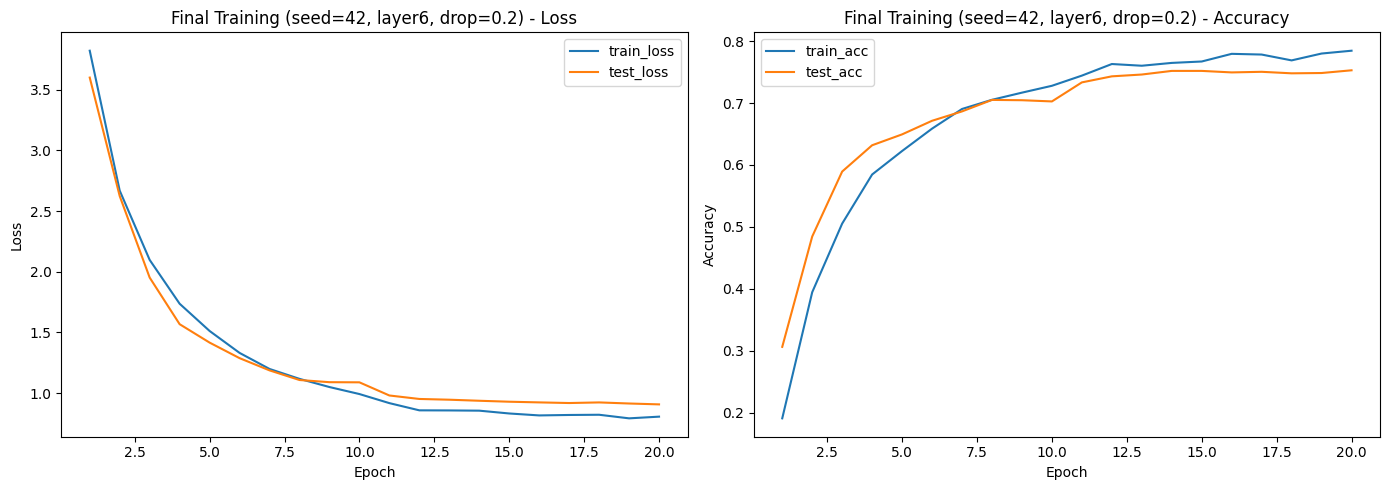


############################################################
# FINAL TRAINING - SEED 123
############################################################
  Training samples: 6141 (train+val combined)
  Test samples: 2048

PHASE 1: Training head for 10 epochs (seed=123)
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.1081 - loss: 4.2234 
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.3783 - loss: 2.7951 
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.4841 - loss: 2.1771 
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.5821 - loss: 1.7598 
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6303 - loss: 1.4776 
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6694 - loss: 1.3254 
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.6915 - loss: 1.1964 
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7130 - loss: 1.1062 
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 105s 1s

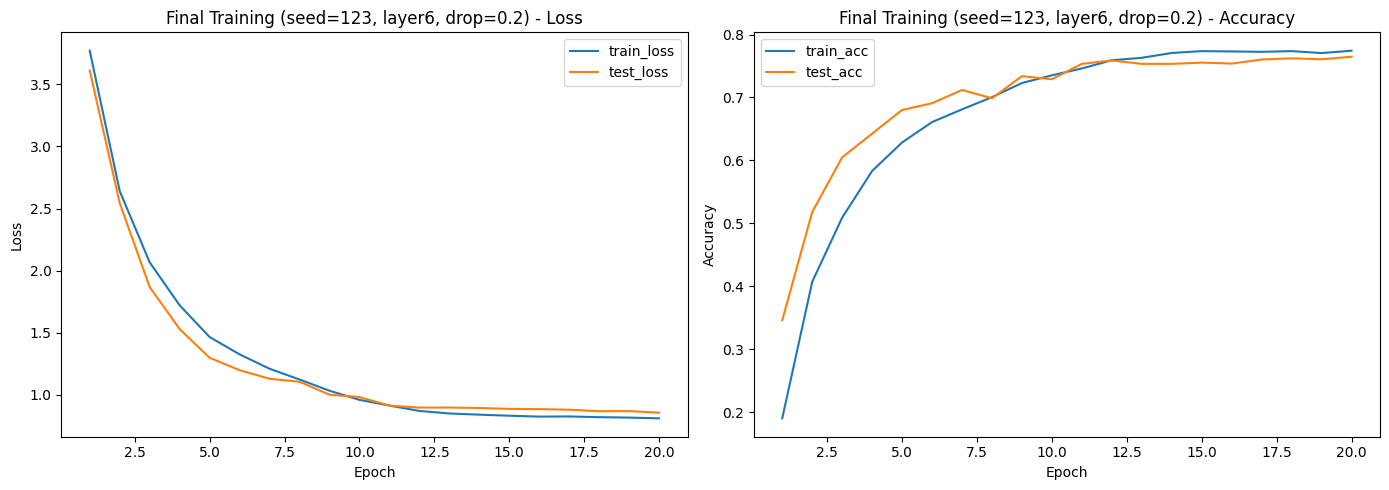


FINAL TRAINING SUMMARY:
   seed  total_epochs  final_train_acc  final_test_acc
0    42            20         0.784563        0.752930
1   123            20         0.774304        0.764648

Average test accuracy: 0.7588
Results saved to: /Users/itamartalpaz/GitHub/ml-course-assign4/YOLOV5/outputs/results/final_training_summary.csv



In [18]:
# --- PLOT TRAINING CURVES ---

def plot_curves(history, title="Training Curves"):
    """Plot loss and accuracy curves. Handles train, val, and test metrics."""
    import matplotlib.pyplot as plt
    
    epochs = range(1, len(history["loss"]) + 1)
    
    # Check what metrics are available
    has_val = "val_loss" in history
    has_test = "test_accuracy" in history
    
    # Plot Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["loss"], label="train_loss")
    if has_val:
        plt.plot(epochs, history["val_loss"], label="val_loss")
    if has_test:
        plt.plot(epochs, history["test_loss"], label="test_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " - Loss")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["accuracy"], label="train_acc")
    if has_val:
        plt.plot(epochs, history["val_accuracy"], label="val_acc")
    if has_test:
        plt.plot(epochs, history["test_accuracy"], label="test_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title + " - Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run final training for both seeds with best hyperparameters
final_results = []

for seed in SEEDS:
    print(f"\n{'#'*60}")
    print(f"# FINAL TRAINING - SEED {seed}")
    print(f"{'#'*60}")

    # Unpack 5 values including history_path
    model, history, test_loss, test_acc, hist_path = run_final_training(
        seed=seed,
        unfreeze_from=BEST_UNFREEZE_FROM,
        dropout=BEST_DROPOUT
    )

    # Store results
    results = {
        "seed": seed,
        "unfreeze_from": BEST_UNFREEZE_FROM,
        "dropout": BEST_DROPOUT,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "final_train_loss": history["loss"][-1],
        "final_test_loss": test_loss,
        "total_epochs": FINAL_EPOCHS_HEAD + FINAL_EPOCHS_FINETUNE,
        "final_train_acc": history["accuracy"][-1],
        "final_test_acc": test_acc,
        "history_path": hist_path
    }
    final_results.append(results)

    # Plot curves for this seed
    unfreeze_str = "frozen" if BEST_UNFREEZE_FROM is None else f"layer{BEST_UNFREEZE_FROM}"
    plot_curves(history, f"Final Training (seed={seed}, {unfreeze_str}, drop={BEST_DROPOUT})")

# Create summary DataFrame
final_df = pd.DataFrame(final_results)
final_summary_path = os.path.join(BASE_OUTPUT_DIR, "outputs/results/final_training_summary.csv")
final_df.to_csv(final_summary_path, index=False)

print(f"\n{'='*60}")
print(f"FINAL TRAINING SUMMARY:")
print(f"{'='*60}")
print(final_df[["seed", "total_epochs", "final_train_acc", "final_test_acc"]])

print(f"\nAverage test accuracy: {final_df['final_test_acc'].mean():.4f}")
print(f"Results saved to: {final_summary_path}")
print(f"{'='*60}\n")

## Plotting results nicely for the report

Loading history from: HPO/history/seed42_unfreezelayer6_drop0.2.json
Loading history from: HPO/history/seed123_unfreezelayer9_drop0.2.json

Saved HPO plot to: /Users/itamartalpaz/GitHub/ml-course-assign4/YOLOV5/outputs/figures/hpo_best_results.png


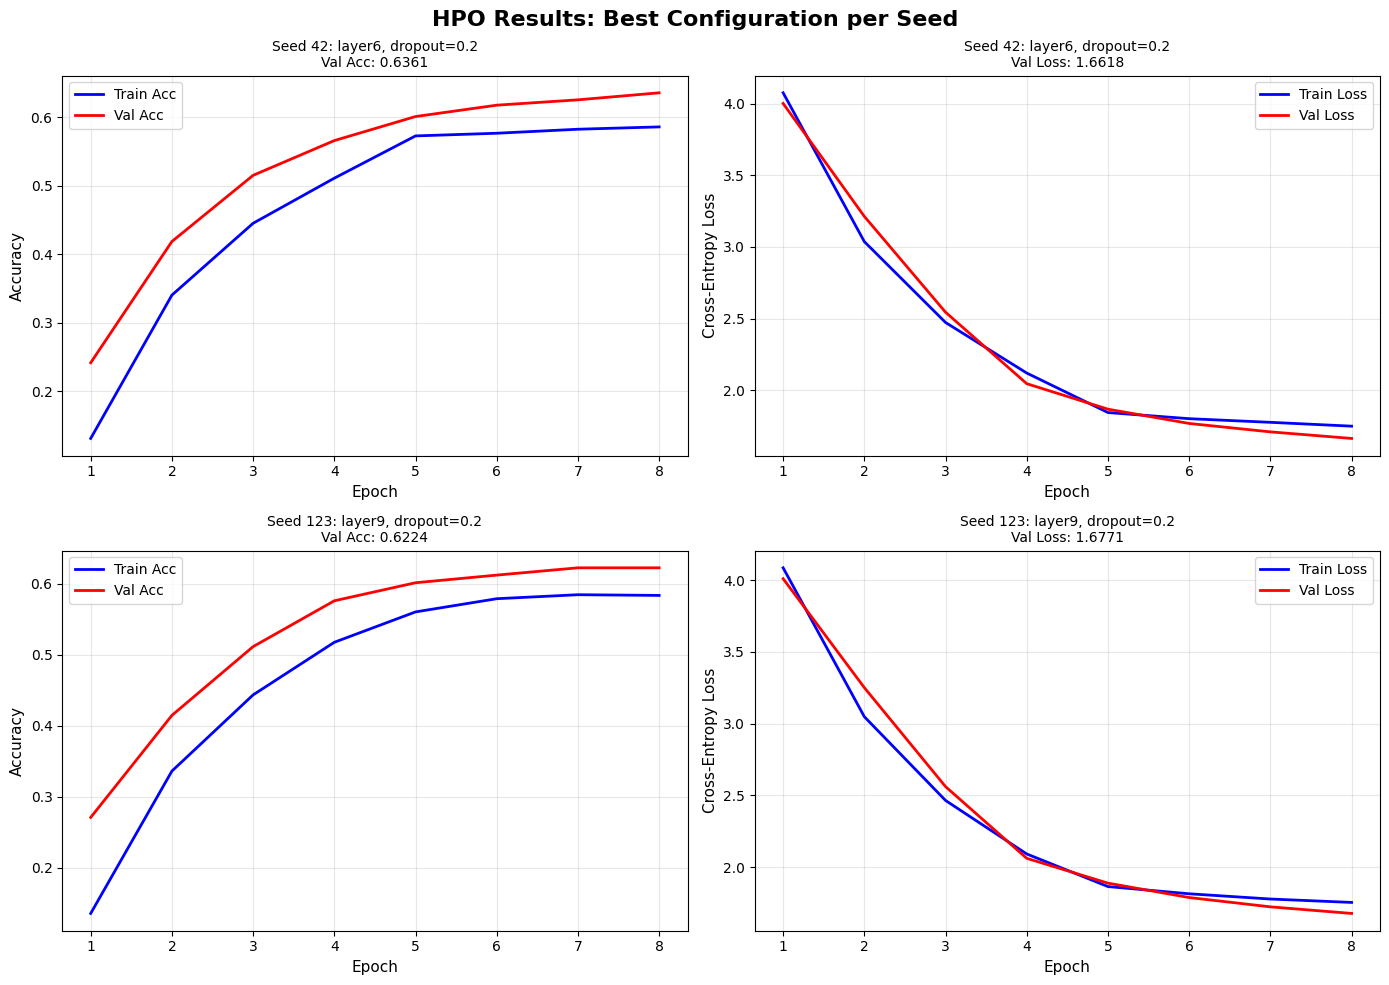

In [20]:
# Load HPO results and create plots for best configurations
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import os

# Load best configurations for each seed
best_params_df = pd.read_csv("HPO/results/best_over_seeds.csv")

# Create figure with 2 rows (one per seed) x 2 cols (accuracy, loss)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("HPO Results: Best Configuration per Seed", fontsize=16, fontweight='bold')

for idx, seed in enumerate(SEEDS):
    # Get best config for this seed
    best_row = best_params_df[best_params_df['seed'] == seed].iloc[0]
    unfreeze = best_row['unfreeze_from']
    dropout = best_row['dropout']

    # Load history - fix the path
    hist_path = best_row['history_path']
    
    # Try to fix the path if it doesn't exist
    if not os.path.exists(hist_path):
        # Try relative to BASE_OUTPUT_DIR
        hist_path = os.path.join(BASE_OUTPUT_DIR, hist_path)
        
    if not os.path.exists(hist_path):
        # Try assuming it's in HPO/history/
        hist_filename = os.path.basename(hist_path)
        hist_path = os.path.join("HPO/history", hist_filename)
    
    print(f"Loading history from: {hist_path}")
    
    with open(hist_path, 'r') as f:
        history = json.load(f)

    epochs = range(1, len(history['loss']) + 1)

    # Plot accuracy
    ax_acc = axes[idx, 0]
    ax_acc.plot(epochs, history['accuracy'], 'b-', label='Train Acc', linewidth=2)
    ax_acc.plot(epochs, history['val_accuracy'], 'r-', label='Val Acc', linewidth=2)
    ax_acc.set_xlabel('Epoch', fontsize=11)
    ax_acc.set_ylabel('Accuracy', fontsize=11)
    ax_acc.set_title(f'Seed {seed}: {unfreeze}, dropout={dropout}\nVal Acc: {best_row["best_val_acc"]:.4f}',
                     fontsize=10)
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)

    # Plot loss
    ax_loss = axes[idx, 1]
    ax_loss.plot(epochs, history['loss'], 'b-', label='Train Loss', linewidth=2)
    ax_loss.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax_loss.set_xlabel('Epoch', fontsize=11)
    ax_loss.set_ylabel('Cross-Entropy Loss', fontsize=11)
    ax_loss.set_title(f'Seed {seed}: {unfreeze}, dropout={dropout}\nVal Loss: {best_row["best_val_loss"]:.4f}',
                     fontsize=10)
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)

plt.tight_layout()
hpo_plot_path = os.path.join(BASE_OUTPUT_DIR, "outputs/figures/hpo_best_results.png")
plt.savefig(hpo_plot_path, dpi=300, bbox_inches='tight')
print(f"\nSaved HPO plot to: {hpo_plot_path}")
plt.show()

In [21]:
# HPO Summary Table (averaged over seeds)
print("\n" + "="*80)
print("HPO RESULTS SUMMARY (Averaged over Seeds)")
print("="*80)

# Group by configuration and calculate means
hpo_summary = best_params_df.groupby(['unfreeze_from', 'dropout']).agg({
    'best_val_acc': ['mean', 'std'],
    'best_val_loss': ['mean', 'std'],
    'test_acc': ['mean', 'std'],
    'test_loss': ['mean', 'std']
}).round(4)

# Flatten column names
hpo_summary.columns = ['_'.join(col).strip() for col in hpo_summary.columns.values]
hpo_summary = hpo_summary.reset_index()

# Display table
print(hpo_summary.to_string(index=False))
print("="*80)

# Identify best configuration
best_config_idx = hpo_summary['best_val_acc_mean'].idxmax()
best_config_row = hpo_summary.iloc[best_config_idx]

print(f"\nBEST CONFIGURATION:")
print(f"  Unfreeze from: {best_config_row['unfreeze_from']}")
print(f"  Dropout: {best_config_row['dropout']}")
print(f"  Avg Val Accuracy: {best_config_row['best_val_acc_mean']:.4f} ± {best_config_row['best_val_acc_std']:.4f}")
print(f"  Avg Test Accuracy: {best_config_row['test_acc_mean']:.4f} ± {best_config_row['test_acc_std']:.4f}")
print("="*80 + "\n")

# Save summary table
hpo_summary_path = "outputs/results/hpo_summary_averaged.csv"
hpo_summary.to_csv(hpo_summary_path, index=False)
print(f"Saved HPO summary to: {hpo_summary_path}")



HPO RESULTS SUMMARY (Averaged over Seeds)
unfreeze_from  dropout  best_val_acc_mean  best_val_acc_std  best_val_loss_mean  best_val_loss_std  test_acc_mean  test_acc_std  test_loss_mean  test_loss_std
       layer6      0.2             0.6361               NaN              1.6618                NaN         0.6147           NaN          1.7223            NaN
       layer9      0.2             0.6224               NaN              1.6771                NaN         0.6113           NaN          1.7168            NaN

BEST CONFIGURATION:
  Unfreeze from: layer6
  Dropout: 0.2
  Avg Val Accuracy: 0.6361 ± nan
  Avg Test Accuracy: 0.6147 ± nan

Saved HPO summary to: outputs/results/hpo_summary_averaged.csv


### Final run

Loading final training history from: /Users/itamartalpaz/GitHub/ml-course-assign4/YOLOV5/outputs/history/final_seed42_unfreezelayer6_drop0.2.json
Loading final training history from: /Users/itamartalpaz/GitHub/ml-course-assign4/YOLOV5/outputs/history/final_seed123_unfreezelayer6_drop0.2.json
Saved final training plots to: outputs/figures/final_training_summary.png


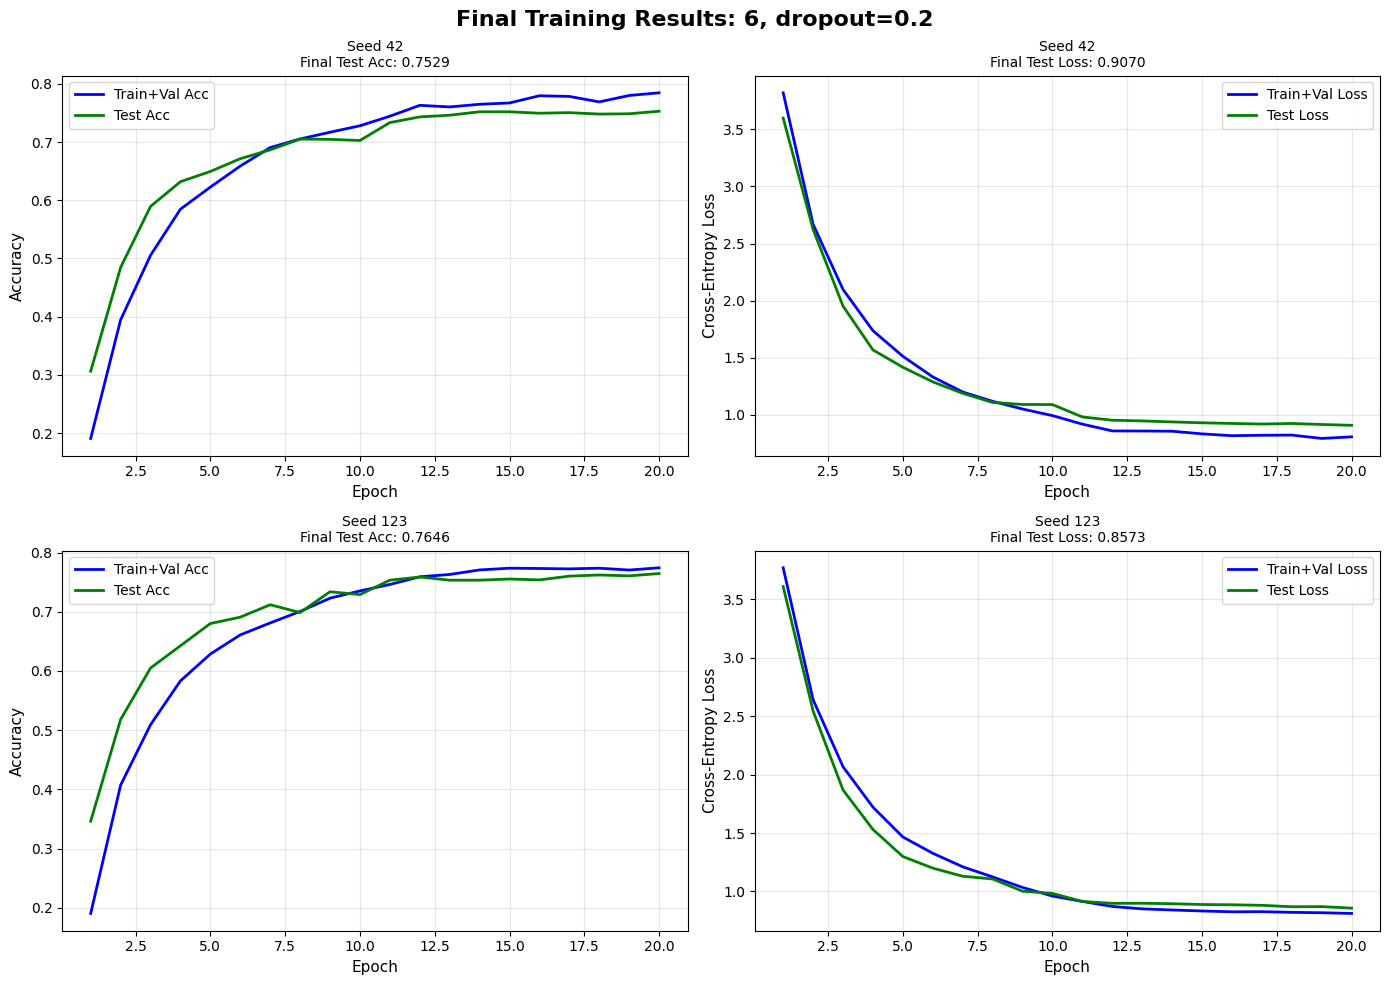

In [23]:
# Load final training results and create plots
final_summary_df = pd.read_csv(BASE_OUTPUT_DIR + "/outputs/results/final_training_summary.csv")

# Create figure with 2 rows (one per seed) x 2 cols (accuracy, loss)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f"Final Training Results: {BEST_UNFREEZE_FROM}, dropout={BEST_DROPOUT}",
             fontsize=16, fontweight='bold')

for idx, seed in enumerate(SEEDS):
    # Get results for this seed
    result_row = final_summary_df[final_summary_df['seed'] == seed].iloc[0]

    # Load history
    print(f"Loading final training history from: {result_row['history_path']}")
    hist_path = result_row['history_path']
    with open(hist_path, 'r') as f:
        history = json.load(f)

    epochs = range(1, len(history['loss']) + 1)

    # Plot accuracy (train+val combined vs test)
    ax_acc = axes[idx, 0]
    ax_acc.plot(epochs, history['accuracy'], 'b-', label='Train+Val Acc', linewidth=2)
    ax_acc.plot(epochs, history['test_accuracy'], 'g-', label='Test Acc', linewidth=2)
    ax_acc.set_xlabel('Epoch', fontsize=11)
    ax_acc.set_ylabel('Accuracy', fontsize=11)
    ax_acc.set_title(f'Seed {seed}\nFinal Test Acc: {result_row["final_test_acc"]:.4f}',
                     fontsize=10)
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)

    # Plot loss
    ax_loss = axes[idx, 1]
    ax_loss.plot(epochs, history['loss'], 'b-', label='Train+Val Loss', linewidth=2)
    ax_loss.plot(epochs, history['test_loss'], 'g-', label='Test Loss', linewidth=2)
    ax_loss.set_xlabel('Epoch', fontsize=11)
    ax_loss.set_ylabel('Cross-Entropy Loss', fontsize=11)
    ax_loss.set_title(f'Seed {seed}\nFinal Test Loss: {result_row["final_test_loss"]:.4f}',
                     fontsize=10)
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)

plt.tight_layout()
final_plot_path = "outputs/figures/final_training_summary.png"
plt.savefig(final_plot_path, dpi=300, bbox_inches='tight')
print(f"Saved final training plots to: {final_plot_path}")
plt.show()


In [24]:
# Final Training Summary Table (averaged over seeds)
print("\n" + "="*80)
print("FINAL TRAINING RESULTS SUMMARY (Averaged over Seeds)")
print("="*80)

# Calculate statistics
final_stats = {
    'Configuration': [f"{BEST_UNFREEZE_FROM}, dropout={BEST_DROPOUT}"],
    'Avg Train Acc': [f"{final_summary_df['final_train_acc'].mean():.4f} ± {final_summary_df['final_train_acc'].std():.4f}"],
    'Avg Test Acc': [f"{final_summary_df['final_test_acc'].mean():.4f} ± {final_summary_df['final_test_acc'].std():.4f}"],
    'Avg Train Loss': [f"{final_summary_df['final_train_loss'].mean():.4f} ± {final_summary_df['final_train_loss'].std():.4f}"],
    'Avg Test Loss': [f"{final_summary_df['final_test_loss'].mean():.4f} ± {final_summary_df['final_test_loss'].std():.4f}"],
    'Total Epochs': [f"{int(final_summary_df['total_epochs'].iloc[0])}"]
}

final_stats_df = pd.DataFrame(final_stats)
print(final_stats_df.to_string(index=False))
print("="*80)

# Per-seed breakdown
print("\nPER-SEED BREAKDOWN:")
print("-"*80)
per_seed_cols = ['seed', 'total_epochs', 'final_train_acc', 'final_test_acc',
                 'final_train_loss', 'final_test_loss']
print(final_summary_df[per_seed_cols].to_string(index=False))
print("="*80 + "\n")

print(f"Average Test Accuracy: {final_summary_df['final_test_acc'].mean():.4f} ± {final_summary_df['final_test_acc'].std():.4f}")
print(f"Average Train-Test Gap: {(final_summary_df['final_train_acc'] - final_summary_df['final_test_acc']).mean():.4f}")
print("="*80 + "\n")



FINAL TRAINING RESULTS SUMMARY (Averaged over Seeds)
 Configuration   Avg Train Acc    Avg Test Acc  Avg Train Loss   Avg Test Loss Total Epochs
6, dropout=0.2 0.7794 ± 0.0073 0.7588 ± 0.0083 0.8089 ± 0.0043 0.8821 ± 0.0351           20

PER-SEED BREAKDOWN:
--------------------------------------------------------------------------------
 seed  total_epochs  final_train_acc  final_test_acc  final_train_loss  final_test_loss
   42            20         0.784563        0.752930          0.805847         0.906968
  123            20         0.774304        0.764648          0.811872         0.857314

Average Test Accuracy: 0.7588 ± 0.0083
Average Train-Test Gap: 0.0206

